In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Import dependencies

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, SpatialDropout2D
from keras.optimizers import RMSprop
from keras.preprocessing import image 
from keras import backend as K
import os
import numpy as np
from keras.applications.resnet50 import preprocess_input
import PIL.ImageOps    
from keras.utils import np_utils
np.random.seed(23)


Using TensorFlow backend.


# Load the Hanacaraka Dataset
Dataset courtesy of Muhammad Soleh, HPC Lab 1231 Fasilkom UI

X_train original shape: (5100, 60, 78, 1)
X_train shape: (2000, 60, 78, 1)
2000 train samples
1000 test samples


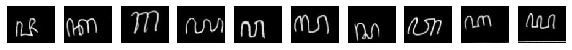

In [2]:
folder = 'gdrive/My Drive/dataset/hanacaraka/'

# Settings
img_rows, img_cols = 60, 78         
nb_classes = 20
number_of_data = 2000

X_train = []
Y_train = []

for cl, fld in enumerate(os.listdir(folder)):
        for f in os.listdir(folder + fld):
                img = image.load_img(folder + fld + '/' + f, grayscale=True, 
                                     target_size=(img_rows, img_cols))
                img = PIL.ImageOps.invert(img)
                img = image.img_to_array(img)
                X_train.append(img.reshape((img_rows, img_cols, 1)))
                Y_train.append(cl)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

shuffled_indices = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffled_indices] 
Y_train = Y_train[shuffled_indices] 
X_test = X_train[X_train.shape[0]//2:]
X_train = X_train[:X_train.shape[0]//2]

Y_test = Y_train[Y_train.shape[0]//2:]
Y_train = Y_train[:Y_train.shape[0]//2]

print('X_train original shape:', X_train.shape)

if K.image_dim_ordering() == 'th':
    # For Theano backend
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    # For TensorFlow backend
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Split train test
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

test_data = 1000

X_train = X_train[:number_of_data]
Y_train = Y_train[:number_of_data]
X_test = X_test[:test_data]
Y_test = Y_test[:test_data]

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
    

# Visualize Hanacaraka dataset
import matplotlib.pyplot as plt
%matplotlib inline

n = 10  
plt.figure(figsize=(10, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(img_rows, img_cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Convolutional Neural Network

## Build

In [19]:
# Settings
pool_size = (3, 3)                  # size of pooling area for max pooling
prob_drop_conv = 0.25              # drop probability for dropout @ conv layer
prob_drop_hidden = 0.3              # drop probability for dropout @ fc layer

# Convolutional model
model = Sequential()

# conv1 layer
model.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'))

# conv2 layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'))

# conv2 layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'))

# fc input layer
model.add(Flatten())
model.add(Dropout(prob_drop_hidden))

# fc1 layer
model.add(Dense(5120, activation='relu'))
model.add(Dropout(prob_drop_hidden))

# fc2 layer
model.add(Dense(nb_classes, activation='softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 60, 78, 8)         80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 39, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 39, 32)        2336      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 20, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 10, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5120)              0         
__________

## Train

In [20]:
# Settings
batch_size = 128
epochs = 200

# Train
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)

Epoch 1/200
2000/2000 [==============================] - 2s 799us/step - loss: 3.0000 - acc: 0.0555
Epoch 2/200
2000/2000 [==============================] - 1s 342us/step - loss: 2.9885 - acc: 0.0625
Epoch 3/200
2000/2000 [==============================] - 1s 354us/step - loss: 2.9799 - acc: 0.0635
Epoch 4/200
2000/2000 [==============================] - 1s 356us/step - loss: 2.9745 - acc: 0.0775
Epoch 5/200
2000/2000 [==============================] - 1s 360us/step - loss: 2.9654 - acc: 0.0865
Epoch 6/200
2000/2000 [==============================] - 1s 354us/step - loss: 2.9550 - acc: 0.0965
Epoch 7/200
2000/2000 [==============================] - 1s 359us/step - loss: 2.9448 - acc: 0.1050
Epoch 8/200
2000/2000 [==============================] - 1s 351us/step - loss: 2.9308 - acc: 0.1025
Epoch 9/200
2000/2000 [==============================] - 1s 354us/step - loss: 2.9180 - acc: 0.1135
Epoch 10/200
2000/2000 [==============================] - 1s 366us/step - loss: 2.8987 - acc: 0.1195

## Evaluate

In [23]:
evaluation = model.evaluate(X_test, Y_test, batch_size=256, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

1000/1000 [==============================] - 0s 104us/step
Summary: Loss over the test dataset: 0.95, Accuracy: 0.80
